<a href="https://colab.research.google.com/github/Abebayehu-Alaro/AUTOMATED-COURSE-REGISTRATION-RESULT-PROCESSING-SYSTEM/blob/master/Copy_of_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries, opencv and numpy

In [29]:
import cv2 as cv
import numpy as np
import matplotlib
import os
from google.colab.patches import cv2_imshow
from google.colab import files


In [25]:
SZ=20
bin_n = 16 
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR
count=0

Before finding the HOG(Histogram Oreineted Gradient), as features vector, we deskew the image using its second order moments. So we first define a function deskew() which takes a digit image and deskew it. Below is the deskew() function:

In [31]:
def deskew(img):
    global count
    if count==0:
      print("The original image")
      cv2_imshow(img)
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    if count==0:
      print("The deskewed image")
      cv2_imshow(img)
      count=count+1
    
    return img

Next we have to find the HOG Descriptor of each cell. For that, we find Sobel derivatives of each cell in X and Y direction. Then find their magnitude and direction of gradient at each pixel. This gradient is quantized to 16 integer values. Divide this image to four sub-squares. For each sub-square, calculate the histogram of direction (16 bins) weighted with their magnitude. So each sub-square gives you a vector containing 16 values. Four such vectors (of four sub-squares) together gives us a feature vector containing 64 values. This is the feature vector we use to train our data.

In [11]:
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

In [12]:
!mkdir uploads

In [49]:
uploaded = files.upload()
uploaded_files = list(uploaded.keys())
for uploaded_file in uploaded_files:
  print(uploaded_file)
  !mv $uploaded_file uploads/$uploaded_file

Saving test_7.png to test_7.png
test_7.png


In [50]:
uploads_dir = "/content/uploads"
IMAGE_PATH = ""

for filename in os.listdir(uploads_dir):
    IMAGE_PATH=os.path.join(uploads_dir, filename)



Importing the digit dataset

In [51]:
img = cv.imread(IMAGE_PATH, 0)
if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

We split our big dataset into individual cells. For every digit, 250 cells are reserved for training data and remaining 250 data is reserved for testing

In [17]:
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]


First half is for training and the next half is for testing 

In [27]:
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]

Calling deskew function to deskew the given cell

In [32]:
deskewed = [list(map(deskew,row)) for row in train_cells]

The original image


The deskewed image


Calling the hog function to find the HOG Descriptor of each cell

In [33]:
hogdata = [list(map(hog,row)) for row in deskewed]


In [34]:
trainData = np.float32(hogdata).reshape(-1,64)

In [35]:
responses = np.repeat(np.arange(10),250)[:,np.newaxis]

Making ready the classfier by setting different parameters

In [36]:
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

Training the classfier

In [37]:
svm.train(trainData, cv.ml.ROW_SAMPLE, responses)

True

Saving the trained the classifier weight

In [38]:
svm.save('svm_data.dat')

Testing the **classfier**

In [39]:
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]

**Testing the trained classfier**
<br>importing the file

In [57]:
uploaded = files.upload()
uploaded_files = list(uploaded.keys())
for uploaded_file in uploaded_files:
  print(uploaded_file)
  !mv $uploaded_file uploads/$uploaded_file

Saving test_7.png to test_7.png
test_7.png


In [58]:
uploads_dir = "/content/uploads"
IMAGE_PATH = ""

for filename in os.listdir(uploads_dir):
    IMAGE_PATH=os.path.join(uploads_dir, filename)

In [59]:
test_img = cv.imread(IMAGE_PATH, 0)
if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

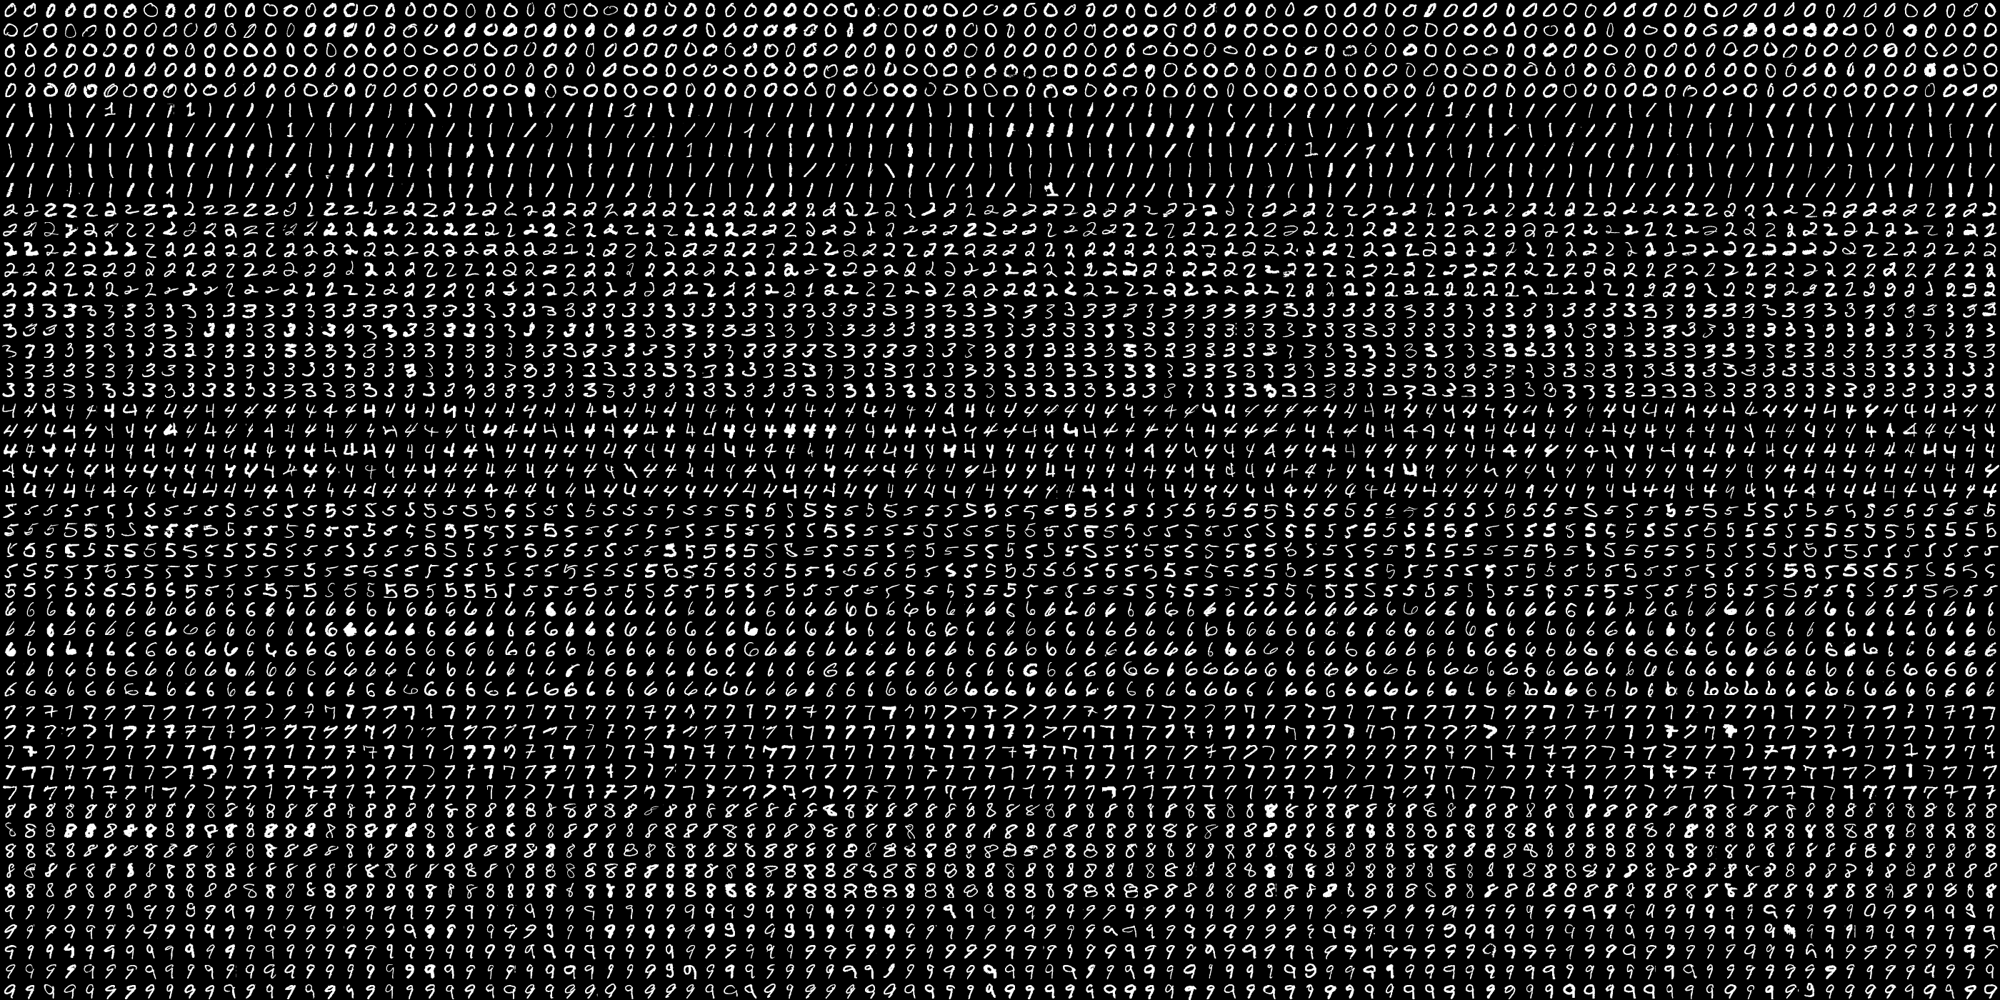

In [60]:
cv2_imshow(test_img)
deskewed = deskew(test_img)
hogdata = hog(deskewed)
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]

In [47]:
print(result)

[[0.]]


Checking the Accuracy

In [ ]:
mask = result==responses
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

93.84
